Используем предварительно обученную модель BERT для классификации тональности отзывов на фильмы

In [ ]:
# установим и загрузим библиотеки
import os
! pip install pymorphy2
!pip install wordcloud
!pip install natasha
!pip install transformers
import pymorphy2
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc

from sklearn.feature_extraction.text import*
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from nltk.tag import UnigramTagger
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from natasha import MorphVocab, NewsEmbedding, NewsSyntaxParser, NamesExtractor, NewsMorphTagger, Doc, Segmenter, NewsNERTagger
import torch
from transformers import BertTokenizer, AutoModel

import wordcloud
from wordcloud import WordCloud

import matplotlib
import matplotlib.pyplot as plt

import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")
import gdown

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [ ]:
# загрузим токенизатор Bert
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
# загрузим наш датасет
dataset_id = '1RZJzx3nQlgmxKG-l3p7KldWBl_HVW3N9'
gdown.download(id = dataset_id)

Downloading...
From: https://drive.google.com/uc?id=1RZJzx3nQlgmxKG-l3p7KldWBl_HVW3N9
To: /content/IMDB Dataset.csv
100%|██████████| 66.2M/66.2M [00:01<00:00, 37.7MB/s]


'IMDB Dataset.csv'

In [ ]:
# выведем датасет
data = pd.read_csv(f"IMDB Dataset.csv")
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
# посмотрим описательную статистику на датасету
data.describe(include = ['object'])

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
# Посмотрим уникальные значения по эмоциональной окраске
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
# Переведем категориальный признак в числовой для нашего удобства
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# определим нашу целевую переменную y
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

In [ ]:
# определим нашу модель BERT
BERT_HUGGING_MODEL = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL, do_lower_case=True)

In [ ]:
# создадим функцию предобработки данных
def preprocessing_for_bert(data):
    """Препроцессинг на модели  BERT.
    @param    data (np.array): Текст для препроц.
    @return   input_ids (torch.Tensor): Либо id token, либо объект тензор.
    @return   attention_masks (torch.Tensor): Определяем набор токенов (объекты тензоры) для работы мехонизма внимания.
    """
    # Для выходных данных пустые списки
    input_ids = []
    attention_masks = []

    # Цикл по данным
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length, заполнение даннх
            return_attention_mask=True      # Return attention mask
            )

        # Добавление обработанных (закодированных данных) в списки id, masks
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Преобразуем в тензоры
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)


    return input_ids, attention_masks

In [ ]:
MAX_LEN = 256
train_inputs, train_masks = preprocessing_for_bert(X_train)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# преобразуем объект Series в массив

if isinstance(y_train, pd.Series):
    y_train=y_train.to_numpy() # преобразуем объект Series в массив

if isinstance(y_test, pd.Series):
    y_test=y_test.to_numpy() # преобразуем объект Series в массив

train_labels = torch.LongTensor(y_train) # делаем из numpy array LongTensor
test_labels = torch.LongTensor(y_test) # делаем из numpy array LongTensor

# batch size: 16 и 32.
batch_size = 16

# TensorDataset: входные данные (отзывы), маски для отзывов, с чем сравнивать
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# RandomSampler: входные данные (отзывы)
train_sampler = RandomSampler(train_data)
# RandomSampler: входные данные (отзывы), batch_size, RandomSampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# создадим класс модели
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.3), LSTM, GRU
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Смотрим CLS - начало предложения (определяем отзыв)
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)
        return logits

In [ ]:
# определим количество эпох для обучения
EPOCH_NUM = 4

def initialize_model(epochs=EPOCH_NUM):
    # фризим BertClassifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Задаем устройство (GPU T4)
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate
                      eps=1e-8    # epsilon - точность функции, до какого значения считать
                      )

    # Расчет циклов для работы
    total_steps = len(train_dataloader) * epochs

    # Загрузчик, расписание (последовательность) и число циклов для обучения
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# Функция потерь (бинарная классификация)
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):
  '''
  Воспроизводимость модели, по умолчанию seed_value=42
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):
    """

      Тренировка BertClassifier model

    """
    print("Начало тренировки...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Измерение времени (elapsed time of each epoch)
        t0_epoch, t0_batch = time.time(), time.time()

        # Обнулить переменные
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Перевод в режим тренировки
        model.train()

        # Для каждого batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Загружаем каждую batch в GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Использование нулевого градиента
            model.zero_grad()

            # Добавляем в модель id и маски
            logits = model(b_input_ids, b_attn_mask)

            # Считаем потери (Кросс Энтропия)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Расчет градиентов функцией backward
            loss.backward()

            # Решение проблемы "взрывных градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Обновляем шаг для оптимизатора и расписания
            optimizer.step()
            scheduler.step()

            # Печатаем значения для каждых 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Время расчета 20 batches
                time_elapsed = time.time() - t0_batch

                # Результаты
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Обнулим переменные
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Средняя функция потерь
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Оценка
        # =======================================
        if evaluation == True:
            # Считается точность
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # Общее время, затраченное на измерение
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Обучение завершилось")

In [ ]:
# определим функцию оценки качества нашей модели
def evaluate(model, test_dataloader):

    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [ ]:
# проверим используемые мощности
device = torch.device("cuda")

In [ ]:
# определим параметры для обучения
set_seed(1)    # установим seed for вопроизводимости результатов
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, test_dataloader, epochs=1, evaluation=True)

Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.633910   |     -      |     -     |   16.28  
   1    |   40    |   0.466143   |     -      |     -     |   13.32  
   1    |   60    |   0.412709   |     -      |     -     |   13.57  
   1    |   80    |   0.419528   |     -      |     -     |   13.97  
   1    |   100   |   0.344232   |     -      |     -     |   14.35  
   1    |   120   |   0.322254   |     -      |     -     |   14.07  
   1    |   140   |   0.288121   |     -      |     -     |   13.81  
   1    |   160   |   0.304398   |     -      |     -     |   13.68  
   1    |   180   |   0.320444   |     -      |     -     |   13.81  
   1    |   200   |   0.262578   |     -      |     -     |   13.81  
   1    |   220   |   0.281502   |     -      |     -     |   13.88  
   1    |   240   |   0.320196   |     -      |     -     |   13.90

In [ ]:
# соберем функцию по предсказанию класса объекта
def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Сбор из каждого batch результатов в один объект
    all_logits = torch.cat(all_logits, dim=0)

    # вероятность принадлежности к классу
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# построим визуализацию оценки модели
%matplotlib inline

def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Посмотрим accuracy по тестовой выборке
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # ROC AUC
    plt.title('Оценка ROC AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9770
Accuracy: 92.17%


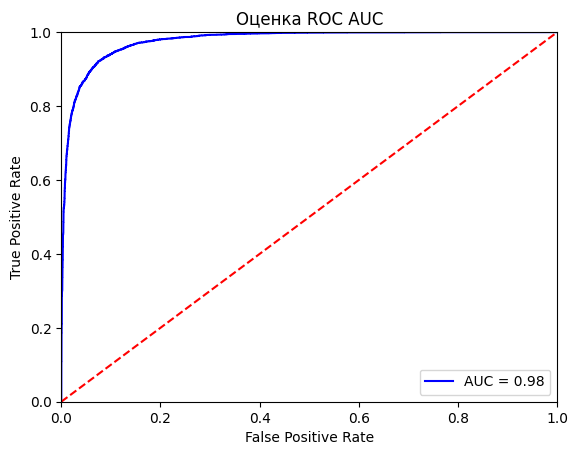

In [ ]:
# Вычислим предсказанную вероятность на тестовой выборке
probs = bert_predict(bert_classifier, test_dataloader)

# Оценим классификатор Bert
evaluate_roc(probs, y_test)

Качество нашей модели высокое